In [85]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from joblib import Parallel, delayed

In [78]:
IS_ILLUSTRATED = True
if IS_ILLUSTRATED:
    %matplotlib inline
    import pandas as pd
    import seaborn as sns
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [9]:
import cofacto
import rec_eval
import cofacto_util as util

In [120]:
import imp
cofacto = imp.reload(cofacto)
rec_eval = imp.reload(rec_eval)
util = imp.reload(util)

In [57]:
### Preprocess data

In [58]:
DATA_DIR = '../data/'
fn_uid_sids = 'sample_uid_sids.txt'

In [59]:
idx2uid, uid2idx, idx2sid, sid2idx = util.make_index(os.path.join(DATA_DIR, fn_uid_sids))

In [60]:
uid_sids_dict = util.make_uid_sids_dict(os.path.join(DATA_DIR, fn_uid_sids))

In [61]:
fn_train, fn_dev, fn_test = util.make_train_dev_test_files(idx2uid, uid2idx, idx2sid, sid2idx, uid_sids_dict)
print(fn_train, fn_dev, fn_test)

data_train.txt data_dev.txt data_test.txt


In [62]:
n_users = len(uid2idx)
print('n_users:{}'.format(n_users))
n_items = len(sid2idx)
print('n_items:{}'.format(n_items))

n_users:31677
n_items:63153


In [63]:
### Construct the positive pairwise mutual information (PPMI) matrix

In [66]:
train_data = util.load_input_data(fn_train, shape=(n_users, n_items))

In [75]:
watches_per_item = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()
print("The mean (median) watches per item is %d (%d)" % (watches_per_item.mean(), np.median(watches_per_item)))

The mean (median) watches per item is 4 (1)


In [76]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()
print("The mean (median) items each user wathced is %d (%d)" % (user_activity.mean(), np.median(user_activity)))

The mean (median) items each user wathced is 8 (4)


In [77]:
vad_data = util.load_input_data(fn_dev, shape=(n_users, n_items))

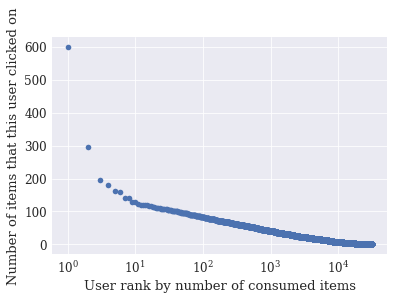

In [81]:
if IS_ILLUSTRATED:
    plt.figure()
    plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
    plt.ylabel('Number of items that this user clicked on')
    plt.xlabel('User rank by number of consumed items')

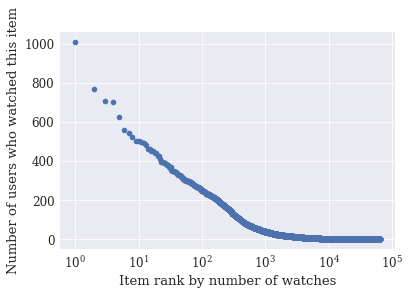

In [82]:
if IS_ILLUSTRATED:
    plt.figure()
    plt.semilogx(1 + np.arange(n_items), -np.sort(-watches_per_movie), 'o')
    plt.ylabel('Number of users who watched this item')
    plt.xlabel('Item rank by number of watches')

In [83]:
### Generate co-occurrence matrix based on the user's entire watching history

In [87]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in range(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))

In [88]:
batch_size = 5000

start_idx = list(range(0, n_users, batch_size))
end_idx = start_idx[1:] + [n_users]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, train_data) for lo, hi in zip(start_idx, end_idx))

[None, None, None, None, None, None, None]

In [89]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 20000 finished
User 20000 to 25000 finished
User 25000 to 30000 finished
User 30000 to 31677 finished


In [90]:
# rm coo_*

In [91]:
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_data.npy'), X.data)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indices.npy'), X.indices)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indptr.npy'), X.indptr)

In [95]:
print('co-occurrence matrix X sparcity:{}'.format(float(X.nnz) / np.prod(X.shape)))

co-occurrence matrix X sparcity:0.0011928090462934218


In [96]:
### load the pre-saved co-occurrence matrix

In [97]:
dir_predix = DATA_DIR

In [98]:
data = np.load(os.path.join(dir_predix, 'coordinate_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indptr.npy'))

In [99]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [100]:
print('co-occurrence matrix X sparcity:{}'.format(float(X.nnz) / np.prod(X.shape)))

co-occurrence matrix X sparcity:0.0011928090462934218


In [101]:
### Construct the SPPMI matrix

In [102]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [103]:
count = np.asarray(X.sum(axis=1)).ravel()

In [104]:
n_pairs = X.data.sum()

In [105]:
M = X.copy()

for i in range(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [106]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [107]:
# Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [108]:
print('PPMI matrix M sparcity:{}'.format(float(M.nnz) / np.prod(M.shape)))

PPMI matrix M sparcity:0.0011428088132242765


In [113]:
k_ns = 1 # number of negative samples

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

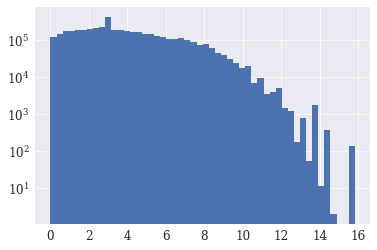

In [114]:
if IS_ILLUSTRATED:
    plt.figure()
    plt.hist(M_ns.data, bins=50)
    plt.yscale('log')
    pass

In [115]:
print('SPPMI matrix M_ns sparcity:{}'.format(float(M_ns.nnz) / np.prod(M_ns.shape)))

SPPMI matrix M_ns sparcity:0.0011428088132242765


In [116]:
### train

In [117]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(DATA_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [122]:
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [123]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=31.23
	Updating item factors: time=90.72
	Updating context factors: time=87.91
	Updating bias terms: time=62.19


/home/work/notebook/cofacto/src/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


	Validation NDCG@k: 0.00000
ITERATION #1
	Updating user factors: time=34.15
	Updating item factors: time=92.89
	Updating context factors: time=83.67
	Updating bias terms: time=62.74
	Validation NDCG@k: 0.00000
ITERATION #2
	Updating user factors: time=31.52
	Updating item factors: time=87.58
	Updating context factors: time=81.33
	Updating bias terms: time=61.75
	Validation NDCG@k: 0.00000
ITERATION #3
	Updating user factors: time=35.35
	Updating item factors: time=97.00
	Updating context factors: time=89.47
	Updating bias terms: time=62.71
	Validation NDCG@k: 0.00000
ITERATION #4
	Updating user factors: time=34.28
	Updating item factors: time=96.12
	Updating context factors: time=81.70
	Updating bias terms: time=63.44
	Validation NDCG@k: 0.00000
ITERATION #5
	Updating user factors: time=33.06
	Updating item factors: time=93.88
	Updating context factors: time=85.81
	Updating bias terms: time=62.12
	Validation NDCG@k: 0.00000
ITERATION #6
	Updating user factors: time=31.85
	Updating item

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='../data/ML20M_ns1_scale3.00E-02', save_params=True,
    verbose=True)

In [124]:
test_data = util.load_input_data(fn_test, shape=(n_users, n_items))
test_data.data = np.ones_like(test_data.data)

In [125]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [126]:
print('Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data))
print('Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data))
print('Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))
print('Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))

/home/work/notebook/cofacto/src/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.2043
Test Recall@50: 0.2728


/home/work/notebook/cofacto/src/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


Test NDCG@100: 0.1641
Test MAP@100: 0.0917


In [127]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)

In [130]:
print('done')

done


In [132]:
np.shape(U)

(31677, 100)

In [133]:
np.shape(V)

(63153, 100)

In [161]:
np.matmul(U[1], V[:100, :].T)

array([-0.09325711,  0.8419311 , -0.03598236,  0.03346455, -0.06922927,
        0.19098508, -0.1112763 ,  0.27468157,  0.23556426,  0.07064812,
       -0.18097018,  0.04328102, -0.05030015,  0.10416648,  0.14424825,
        0.01622207,  0.08508852,  0.89381784,  0.08590552,  0.02179617,
        0.08148166,  0.07201698,  0.10841148,  0.10807201,  0.11244121,
        0.06237517,  0.131816  ,  0.02869073,  0.22635257, -0.0225377 ,
        0.26740623, -0.16118535,  0.03500507,  0.2318334 ,  0.0411415 ,
       -0.00998103,  0.04842523,  0.2602375 ,  0.02433515, -0.03937439,
       -0.05306278,  0.0534087 ,  0.06934233,  0.01128462,  0.08226431,
       -0.00398164,  0.00473621, -0.03548691,  0.04436348, -0.0436572 ,
        0.07642476,  0.11830876,  1.1008312 ,  0.00565253,  0.9463146 ,
        0.8451267 ,  0.0492539 ,  0.07082014,  0.08500954,  0.22332905,
        0.00219677,  0.06194504,  0.02961252, -0.04367742,  0.92343   ,
        0.13659304, -0.03582516,  0.15246896,  0.06079533,  0.07

In [209]:
idx2uid[10]
uid2idx['66129187']

3685

In [216]:
res = []
uid = '66129187'
for sid in uid_sids_dict[uid]:
    res.append(np.dot(U[uid2idx[uid]], V[sid2idx[sid]]))
print(res)

[0.7024616, 0.7295533, 0.7673555, 0.8154484, 0.18947008, 0.7538247, 0.795404, 0.8092116, 0.73394334, 0.8093264, 0.77658397, 0.8010469, -0.015609875, 0.80850965, 0.75229573, 0.7531301, 0.7869449, 0.76149195, 0.76127887, 0.7696378, 0.19074099, 0.82476443, 0.80927765, 0.7947824, 0.7885077, 0.114046186, 0.6110305, 0.8661637, -0.0051810443]


In [217]:
ui_mat = np.matmul(U[uid2idx[uid]], V[:, :].T)

In [218]:
topk_idx = np.argpartition(-ui_mat, 50)[:50]

In [219]:
ui_mat[topk_idx]

array([0.8112059 , 0.80932635, 0.8154484 , 0.8621156 , 0.80104685,
       0.80927783, 0.8046349 , 0.8085096 , 0.86616373, 0.8059624 ,
       0.79499716, 0.83456784, 0.82102007, 0.82476443, 0.79606533,
       0.80921155, 0.81143504, 0.79540396, 0.79478246, 0.80609417,
       0.78866607, 0.76735544, 0.7786423 , 0.77331483, 0.7792526 ,
       0.7696379 , 0.7885077 , 0.7765839 , 0.78694487, 0.7694034 ,
       0.7653545 , 0.7591852 , 0.75382465, 0.7614919 , 0.7522365 ,
       0.75229573, 0.7559354 , 0.73188895, 0.7612788 , 0.73394334,
       0.7295532 , 0.74877024, 0.75313014, 0.7048402 , 0.69851184,
       0.7024616 , 0.6866288 , 0.68655616, 0.6110306 , 0.35612133],
      dtype=float32)

In [220]:
arr = []
for idx in topk_idx.tolist():
    arr.append(idx2sid[idx])
print(arr)

['M1034051867', 'M1017537898', 'M1004225499', 'M1015749748', 'M1026716815', 'M967749900', 'M1037242594', 'M1016280242', 'M1016250500', 'M1015907353', 'M1002401720', 'M991182235', 'M1032230936', 'M1014544123', 'M1027438381', 'M1016273453', 'M1004168019', 'M1025707835', 'M1026707758', 'M1016273489', 'M1025708042', 'M1043344208', 'M1030703476', 'M991182322', 'M1317972641', 'M1000802966', 'M974613165', 'M999803376', 'M1036573309', 'M994353918', 'M1004623445', 'M1016039543', 'M1037289913', 'M1029883736', 'M1008303490', 'M1004615185', 'M1312805659', 'M1014909486', 'M969249006', 'M1013116079', 'M1019619550', 'M1002609866', 'M1002987961', 'M964759878', 'M1001219330', 'M1361803693', 'M1025707874', 'M1377496586', 'M1018572263', 'S13620424837245981908']


In [221]:
print(list(uid_sids_dict[uid]))

['M1361803693', 'M1019619550', 'M1043344208', 'M1004225499', 'U57782783767', 'M1037289913', 'M1025707835', 'M1016273453', 'M1013116079', 'M1017537898', 'M999803376', 'M1026716815', 'M1322431554', 'M1016280242', 'M1004615185', 'M1002987961', 'M1036573309', 'M1029883736', 'M969249006', 'M1000802966', 'U57778464659', 'M1014544123', 'M967749900', 'M1026707758', 'M974613165', 'U57735662579', 'M1018572263', 'M1016250500', 'U57739325524']
